<a href="https://colab.research.google.com/github/MuayThaiLegz/PracticeCrazy/blob/main/BTCLSTMNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import yfinance as yf



In [10]:
data = yf.download('BTC-USD', start='2014-09-17', end='2023-03-01')


# Select features
features = ['Open', 'High', 'Low', 'Close', 'Volume']
data = data[features]


[*********************100%***********************]  1 of 1 completed


In [11]:
data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100


In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))

scaled_data = scaler.fit_transform(data.values.reshape(-1,1))


prediction_days = 60: This line is setting the number of days for which predictions will be made. In this case, the model will be trained to predict the value for the next 60 days based on the data from the previous days.

x_train = [] and y_train = []: Here, two empty lists are initialized. They will be filled with the training data (x_train) and the corresponding labels (y_train).

The for loop: This loop is going through the scaled data (which has been previously preprocessed and normalized to fall into a certain range, usually between 0 and 1).

For each point in the data, starting from the prediction_days point up to the end of the data (len(scaled_data)), it is taking a slice of the data from x-prediction_days to x (60 days before the current day up to the current day) and appending it to x_train.

It is also appending the value at the current day (scaled_data[x, 0]) to y_train.

This means that for each day, x_train will contain the previous 60 days of data and y_train will contain the data for the current day. This is a common approach for time series prediction tasks.

x_train, y_train = np.array(x_train), np.array(y_train): This line is converting the lists x_train and y_train into numpy arrays. This is necessary because the model expects the input data to be in the form of numpy arrays.

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)): This line is reshaping x_train to have three dimensions. This is because the LSTM (Long Short-Term Memory) network, which is commonly used for time series prediction tasks, expects the input to be in the form of a 3D array. The dimensions represent the number of samples (number of sequences), the number of time steps (each element in a sequence), and the number of features per time step (in this case, it's 1 because there's only one feature per time step).

In [14]:
prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [15]:
from keras.layers import Flatten

# Build the model
model = Sequential()

# First LSTM layer with Dropout
model.add(LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))

# Third LSTM layer
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))

# Fourth LSTM layer
model.add(LSTM(units=100))
model.add(Dropout(0.2))

# Flatten layer
model.add(Flatten())

# First Dense layer
model.add(Dense(units=100, activation='relu'))
model.add(Dropout(0.2))

# Second Dense layer
model.add(Dense(units=100, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
model.fit(x_train, y_train, epochs=25, batch_size=8)


Epoch 1/25
1922/1922 [==============================] - 37s 15ms/step - loss: 0.0010
Epoch 2/25
1922/1922 [==============================] - 28s 14ms/step - loss: 9.8995e-04
Epoch 3/25
1922/1922 [==============================] - 28s 14ms/step - loss: 8.2410e-04
Epoch 4/25
1922/1922 [==============================] - 28s 14ms/step - loss: 2.2240e-04
Epoch 5/25
1922/1922 [==============================] - 28s 14ms/step - loss: 2.0513e-04
Epoch 6/25
1922/1922 [==============================] - 28s 15ms/step - loss: 2.0976e-04
Epoch 7/25
1140/1922 [================>.............] - ETA: 11s - loss: 1.1040e-04

test_data = yf.download('AAPL', start='2023-03-01', end='2023-05-16'): This line is using the yfinance library to download the stock price data for Apple (ticker symbol 'AAPL') from March 1, 2023, to May 16, 2023. This data will be used as the test set for the model.

actual_prices = test_data['Close'].values: This line is extracting the closing prices from the test data and storing them as a numpy array. These will be the actual values that the model's predictions will be compared against.

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0): This line is concatenating the closing prices from the training data (data['Close']) and the test data (test_data['Close']) into a single pandas Series.

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values: This line is creating the input data for the model, which includes the last prediction_days days of the training data and all of the test data. It is extracting these values as a numpy array.

model_inputs = model_inputs.reshape(-1, 1): This line is reshaping the model inputs into a 2D array, which is required by the scaler.transform function.

model_inputs = scaler.transform(model_inputs): This line is applying the same scaling transformation to the model inputs that was applied to the training data. This ensures that the model inputs are in the same range as the data the model was trained on.

The next section is creating the test sequences in the same way as the training sequences were created. For each day in the test data, it is taking the prediction_days days leading up to it and storing these sequences in x_test.

predictions = model.predict(x_test): This line is using the trained model to make predictions on the test data.

predictions = scaler.inverse_transform(predictions): This line is inverting the scaling transformation on the predictions, converting them back to the original price range.

The rest of the code is creating a plot of the actual closing prices and the predicted closing prices. The plt.plot functions are used to plot the actual and predicted prices, and plt.title, plt.xlabel, plt.ylabel, and plt.legend are used to add a title, labels, and a legend to the plot. The plt.show() function is used to display the plot.

[*********************100%***********************]  1 of 1 completed
3/3 [==============================] - 1s 8ms/step


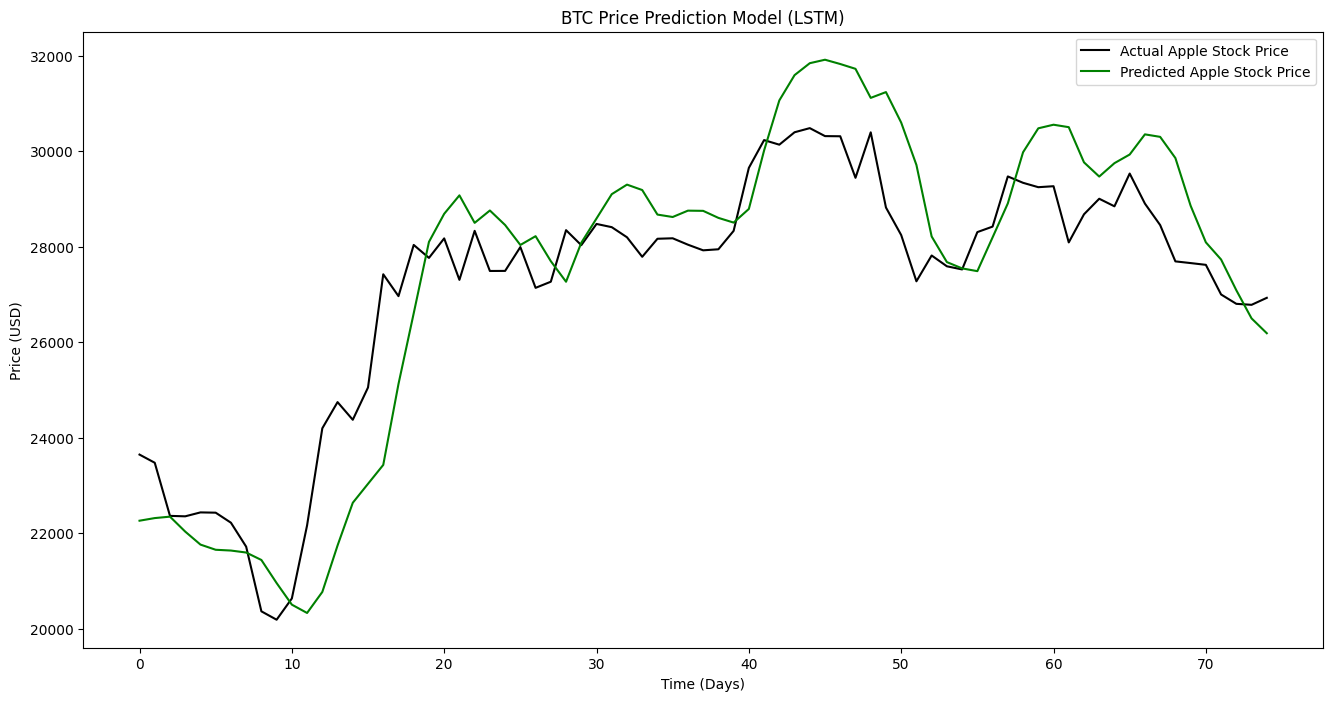

In [9]:

test_data = yf.download('BTC-USD', start='2023-03-01', end='2023-05-15')
actual_prices = test_data.values

total_dataset = pd.concat((data, test_data), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)  # unscaling the values

plt.figure(figsize=(16,8))
plt.title('BTC Price Prediction Model (LSTM)')
plt.xlabel('Time (Days)')
plt.ylabel('Price (USD)')
plt.plot(actual_prices, color='black', label='Actual Apple Stock Price')
plt.plot(predictions, color='green', label='Predicted Apple Stock Price')
plt.legend()
plt.show()